In [9]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [101]:
from scipy.optimize import curve_fit

In [10]:
%matplotlib inline

# Resource modeling in CHIME - Part 2 of n
## A prototype stochastic census submodel

In [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb) of this CHIME resource modeling series, the goal was to:

> try to help people (including myself) better understand the concepts, math and code behind the resource modeling in [CHIME](https://github.com/CodeForPhilly/chime).

In this notebook I want to explore possibilities for using queueing model based approximations for the census projections in CHIME. My primary reasons are:

* current census model is a deterministic, discrete time, "fluid flow" type model and I wonder about the impact of ignoring stochastic effects in length of stay and in number of admits per day.
* a stochastic model offers the possibility of presenting projected census distribution information for each day instead of one fixed point forecast. It's the tails that can get you.
* I've spent a good part of my career building stochastic models, both queueing based and discrete event simulations, for healthcare systems and I've seen the value they can bring.

**Note:** This notebook was created on 2020-04-05 based on CHIME code as of that date.

## Simulate a base scenario

We'll use the same example from [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb). I'll also run the model using the `sim_chime_scenario_runner` wrapper I developed which calls the CHIME model. See Part 1 for details. The important thing is that we'll be working with the exact, unmodified, outputs from the standard CHIME model.

Here are a set of [CHIME input values](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters) for the current model.

    --current-hospitalized 658
    --doubling-time 3.61
    --hospitalized-day 7
    --hospitalized-rate 0.025
    --icu-days 9
    --icu-rate 0.0075
    --market_share 0.32
    --infectious-days 14
    --n-days 120
    --relative-contact-rate 0.31
    --population 5026226
    --ventilated-day 10
    --ventilated-rate 0.005

Let's run the CHIME model for this scenario.

In [1]:
# Import the scenario runner. It will import various penn_chime artifacts.
import sim_chime_scenario_runner as runner

In [2]:
# This scenario name string will get prepended to all output files
scenario = 'base_dt361'

# Create a penn_chime Parameters object
p = runner.create_params_from_file("tests/dt361.cfg") 

# Run the model
model, results = runner.sim_chime(scenario, p) 

2020-04-05 07:33:32,762 - penn_chime.models - INFO - Using doubling_time: 3.61
2020-04-05 07:33:32,801 - penn_chime.models - INFO - Set i_day = 34
2020-04-05 07:33:32,802 - penn_chime.models - INFO - Estimated date_first_hospitalized: 2020-03-02; current_date: 2020-04-05; i_day: 34
2020-04-05 07:33:32,802 - penn_chime.models - INFO - len(np.arange(-i_day, n_days+1)): 155
2020-04-05 07:33:32,803 - penn_chime.models - INFO - len(raw_df): 155


As a reminder, here are the keys in the `results` dictionary. My `sim_chime_scenario_runner.sim_chime()` function just packages up the various dataframes as well as a few dictionaries of variable values into a container dictionary for output processing convenience.

In [3]:
results.keys()

dict_keys(['scenario', 'input_params_dict', 'intermediate_variables_dict', 'sim_sir_w_date_df', 'dispositions_df', 'admits_df', 'census_df'])

This notebook will mostly be using `admits_df`, `census_df` and the `input_params_dict`. So, let's pull them out into variables to save some typing.

In [22]:
print(results['sim_sir_w_date_df'].iloc[32:37, :])

    day       date   susceptible       infected     recovered
32   -2 2020-04-03  4.949471e+06   57286.815104  19468.525608
33   -1 2020-04-04  4.933500e+06   69165.994505  23560.440972
34    0 2020-04-05  4.914279e+06   83446.256336  28500.869151
35    1 2020-04-06  4.898341e+06   93423.926100  34461.316033
36    2 2020-04-07  4.880555e+06  104536.754348  41134.453611


In [4]:
admits_df = results['admits_df']
census_df = results['census_df']
inputs = results['input_params_dict']

Let's take a look at each.

In [5]:
admits_df.head(10)

,day,date,hospitalized,icu,ventilated
0,-34,2020-03-02,NaN,NaN,NaN
1,-33,2020-03-03,0.283108,0.084932,0.056622
2,-32,2020-03-04,0.343034,0.102910,0.068607
3,-31,2020-03-05,0.415643,0.124693,0.083129
4,-30,2020-03-06,0.503619,0.151086,0.100724
5,-29,2020-03-07,0.610214,0.183064,0.122043
6,-28,2020-03-08,0.739366,0.221810,0.147873
7,-27,2020-03-09,0.895847,0.268754,0.179169
8,-26,2020-03-10,1.085437,0.325631,0.217087
9,-25,2020-03-11,1.315137,0.394541,0.263027


In [6]:
census_df.head(10)

,day,date,hospitalized,icu,ventilated
0,-34,2020-03-02,NaN,NaN,NaN
1,-33,2020-03-03,0.283108,0.084932,0.056622
2,-32,2020-03-04,0.626142,0.187843,0.125228
3,-31,2020-03-05,1.041785,0.312536,0.208357
4,-30,2020-03-06,1.545405,0.463621,0.309081
5,-29,2020-03-07,2.155619,0.646686,0.431124
6,-28,2020-03-08,2.894984,0.868495,0.578997
7,-27,2020-03-09,3.790831,1.137249,0.758166
8,-26,2020-03-10,4.593160,1.462881,0.975254
9,-25,2020-03-11,5.565264,1.857422,1.238281


In [7]:
inputs

{'current_hospitalized': 658,
 'hospitalized': Disposition(rate=0.025, days=7),
 'icu': Disposition(rate=0.0075, days=9),
 'ventilated': Disposition(rate=0.005, days=10),
 'region': None,
 'population': 5026226,
 'current_date': datetime.date(2020, 4, 5),
 'date_first_hospitalized': datetime.date(2020, 3, 2),
 'doubling_time': 3.61,
 'relative_contact_rate': 0.31,
 'mitigation_date': None,
 'infectious_days': 14.0,
 'market_share': 0.32,
 'max_y_axis': None,
 'n_days': 120,
 'recovered': 0,
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(rate=0.025, days=7),
  'icu': Disposition(rate=0.0075, days=9),
  'ventilated': Disposition(rate=0.005, days=10)}}

## Current patient flow model in CHIME

The current model strikes a balance between complexity of the model and complexity of inputs required of the user. CHIME models three, somewhat overlapping, resources:

* hospital beds - of any type (e.g. regular, step-down, ICU, etc); it's one big bucket of beds,
* ICU beds - these beds are included in the hospital beds,
* ventilators - anyone using a ventilator is assumed to also be in an ICU bed and thus, in a hospital bed.

Before getting into the details of how use of these resources is modeled, let's step back and see how the arrival streams (or admission rates) are modeled.


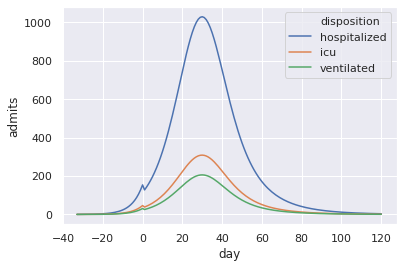

In [11]:
admits_df = results['admits_df']
admits_long = pd.melt(admits_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='admits')


sns.lineplot(x='day', y='admits', hue='disposition', 
             data=admits_long);

In [44]:
hosp_admits = admits_df.loc[:, ['day', 'hospitalized']]
hosp_admits.fillna(0, inplace=True)

In [45]:
hosp_admits

,day,hospitalized
0,-34,0.000000
1,-33,0.283108
2,-32,0.343034
3,-31,0.415643
4,-30,0.503619
...,...,...
150,116,4.454994
151,117,4.198347
152,118,3.956713
153,119,3.729188


In [46]:
hosp_admits['rel_day'] = hosp_admits.index.values

In [47]:
hosp_admits

,day,hospitalized,rel_day
0,-34,0.000000,0
1,-33,0.283108,1
2,-32,0.343034,2
3,-31,0.415643,3
4,-30,0.503619,4
...,...,...,...
150,116,4.454994,150
151,117,4.198347,151
152,118,3.956713,152
153,119,3.729188,153


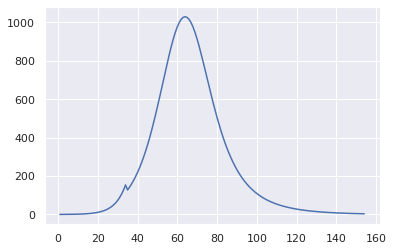

In [17]:
sns.lineplot(data=hosp_admits);

In [60]:
# Compute average arrival rate
lambda_bar = hosp_admits['hospitalized'].mean()
lambda_bar

239.3990216771688

In [109]:
psi_cycle_len_guess = 200
gamma_freq_guess = 2 * math.pi / psi_cycle_len_guess
gamma_freq_guess

0.031415926535897934

In [110]:
# Relative 
alpha_rel_amp_guess = 4

In [111]:
beta_guess = lambda_bar * alpha_rel_amp_guess
beta_guess

957.5960867086752

In [112]:
sin_guess = lambda_bar + beta_guess * np.sin(gamma_freq_guess * hosp_admits.rel_day)
sin_guess

0      239.399022
1      269.477842
2      299.526977
3      329.516774
4      359.417636
          ...    
150   -718.197065
151   -717.724549
152   -716.307468
153   -713.947220
154   -710.646134
Name: rel_day, Length: 155, dtype: float64

In [113]:
x = np.array(hosp_admits.rel_day)
y = np.array(sin_guess)
y_act = hosp_admits['hospitalized']

2020-04-05 10:11:23,960 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


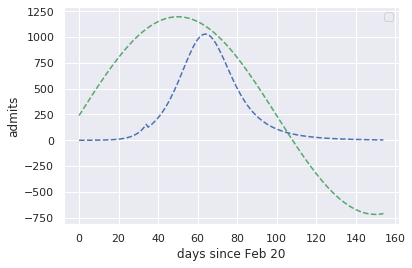

In [114]:
plt.plot(x, y, 'g--')
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

In [115]:
# Function to fit
def sin_func(x, a, b, c):
     return a + b * np.sin(c * x)

In [116]:
popt, pcov = curve_fit(sin_func, x, y_act,  p0=(240, 950, 0.03))
print(popt)

[-8.24497333e+01  5.91986511e+02  2.28486209e-02]


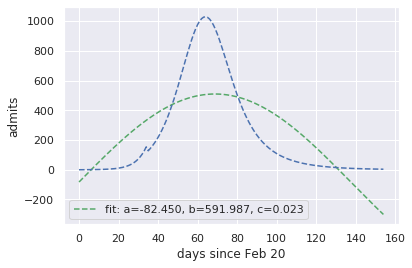

In [117]:
plt.plot(x, func(x, *popt), 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

In [120]:
# Function to fit
def logistic_func(x, a, b, c):
     return a /(1 + b * c ** -x)

In [147]:
(a, b, c) = (1000.0, 100, 1.125)

In [148]:
y1 = np.array(logistic_func(x, a, b, c))

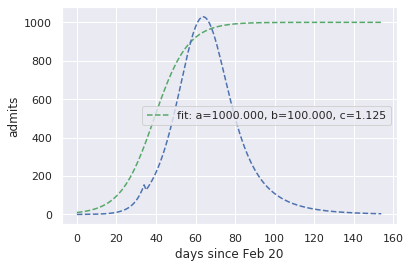

In [149]:
plt.plot(x, y1, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(a, b, c))
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

In [159]:
x_peak = np.argmax(y_act)
y_act_1 = y_act[:x_peak]

In [152]:
x1 = x[:np.argmax(y_act)]
x1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [160]:
popt, pcov = curve_fit(logistic_func, x1, y_act_1,  p0=(a, b, c))
print(popt)

[1.29378304e+03 1.02204732e+03 1.14296202e+00]


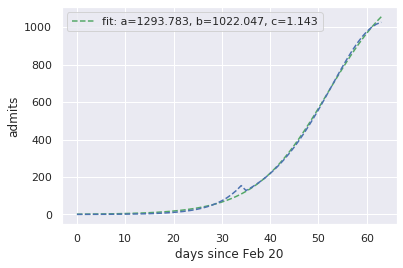

In [163]:
plt.plot(x1, logistic_func(x1, *popt), 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x1, y_act_1, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

### Step 3 - Census
Remember, this is a deterministic model. The user is asked to provide three average length of stay (ALOS) values:

* `hospitalized-day` - average time spent in the hospital by **any covid-19 patient, in any bed type**.
* `icu days` - average time spent in an ICU bed **only for those covid-19 patients who went to an ICU**.
* `ventilated-day` - average time spent on a ventilator **only for those covid-19 patients who were ventilated**

**IMPORTANT** - see the Documentation on user inputs for ALOS at https://code-for-philly.gitbook.io/chime/what-is-chime/parameters#length-of-stay.

### Assumptions and interpretations

There are some other important assumptions and interpretations regarding the interplay between these ALOS values for the different resources.

$$
H \subset C \subset V
$$

Ventilated patients are a subset of ICU patients and ICU patients are a subset of hospitalized patients. This keeps things simpler in the sense that we are estimating average census values for each resource independently by, essentially, multiplying the arrival rate (average number of new dispositions per day) by the appropriate ALOS value (the Python code does this in a different manner but the result is the same). A couple of points:

* for those of you with a bit of queueing or "process physics" knowledge, this is just [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law).
* this model is not in any way looking at details of patient flow patterns such as the fact that patients may take different paths through the hospital:
  - Regular bed --> Discharge
  - Regular bed --> ICU --> Regular/step down --> Discharge
  - Regular bed --> ICU --> Discharge
  - ICU --> Discharge
  - ICU --> Regular/step down --> Discharge
  - Step Down --> Discharge
  - ... etc.
* there is no explicit consideration of capacity limits,
* there is no explicit consideration of parameter uncertainty or stochastic processes.


### Computing average census values
Census can be computed for each resource independently using the `admits_df` DataFrame and the appropriate ALOS value for the resource. Here's the annotated code.

```python
def build_census_df(
    admits_df: pd.DataFrame,
    lengths_of_stay: Dict[str, int],
) -> pd.DataFrame:
    """Average Length of Stay for each disposition of COVID-19 case (total guesses)"""
    return pd.DataFrame({
        'day': admits_df.day,
        'date': admits_df.date,
        **{
            key: (                       # See below for illustration of this computation
                admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
            )
            for key, los in lengths_of_stay.items()
        }
    })
```

Ok, the key line is

```python
admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
```

Let's see how this works.

In [12]:
# Grab the dataframes we need
admits_df = results['admits_df']
census_df = results['census_df']

# Let's look at hospitalized 
key = 'hospitalized'
los = 7

# Make a mini DataFrame with columns to illustrate the computation
admits = admits_df[key]
census = census_df[key]
cum_admits = admits_df[key].cumsum()
shifted_cum_admits = admits_df[key].cumsum().shift(los).fillna(0)

census_demo_df = pd.DataFrame({
    'admits': admits,
    'cum_admits': cum_admits,
    'shifted_cum_admits': shifted_cum_admits,
    'census_computation': cum_admits - shifted_cum_admits,
    'census_chime': census
})

census_demo_df.head(15)

,admits,cum_admits,shifted_cum_admits,census_computation,census_chime
0,NaN,NaN,0.000000,NaN,NaN
1,0.283108,0.283108,0.000000,0.283108,0.283108
2,0.343034,0.626142,0.000000,0.626142,0.626142
3,0.415643,1.041785,0.000000,1.041785,1.041785
4,0.503619,1.545405,0.000000,1.545405,1.545405
5,0.610214,2.155619,0.000000,2.155619,2.155619
6,0.739366,2.894984,0.000000,2.894984,2.894984
7,0.895847,3.790831,0.000000,3.790831,3.790831
8,1.085437,4.876268,0.283108,4.593160,4.593160
9,1.315137,6.191406,0.626142,5.565264,5.565264


Consider day 9. The ALOS is 7 days. So, which admits contribute to census on day 9? Well it's the admits from day 3-9, inclusive (7 days worth). All that the code is doing is summing up all the admits from day 0-9, the `cumsum`, and then subtracting off those from 0-2, the shifted `cumsum`. Doing this prevents us from having to do "index math".

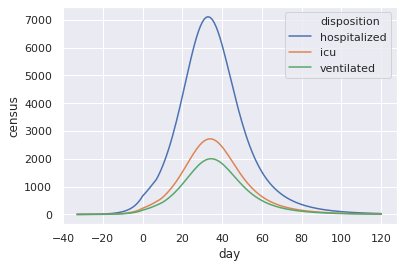

In [47]:
census_df = results['census_df']
census_long = pd.melt(census_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='census')


sns.lineplot(x='day', y='census', hue='disposition', 
             data=census_long);

## Concluding remarks
Hopefully this helps clarify how CHIME is currently computing resource use. In the next notebook, I'll build on this and explore the implied arrival rates and ALOS values for subpopulations of patients such as those covid-19 patients who do NOT use ICU and those ICU patients who do NOT use a vent. These are simple algebraic computations and by feeding them back to users, might help people calibrate their inputs better.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>